In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
from functools import *
from google.colab import auth
auth.authenticate_user()

## **PULL DATA**

In [2]:
project_id = 'windy-ripsaw-309202'

In [3]:
sql_bkt_txn_data = '''
SELECT * FROM `windy-ripsaw-309202.DATA_FOR_CLUSTER.SUM_BKT_ID`
'''
df_bkt_txn = pd.io.gbq.read_gbq(sql_bkt_txn_data , project_id=project_id, verbose=False, dialect="standard")

In [4]:
# '''
# SELECT CUST_CODE, 
# SUM(SPEND) AS TOTAL_SALES, 
# COUNT(DISTINCT BASKET_ID) AS TOTAL_VISIT 
# FROM `windy-ripsaw-309202.DATA_FOR_CLUSTER.DIST_BKT_TYPE_TXN_FULL`
# WHERE CUST_CODE IS NOT NULL 
# GROUP BY CUST_CODE'''
sql_bkt_top ='''
SELECT * , 
FROM `windy-ripsaw-309202.DATA_FOR_CLUSTER.DIST_BKT_TYPE_TXN_TOP`
WHERE CUST_CODE IS NOT NULL '''
sql_bkt_full ='''
SELECT * , 
FROM `windy-ripsaw-309202.DATA_FOR_CLUSTER.DIST_BKT_TYPE_TXN_FULL`
WHERE CUST_CODE IS NOT NULL '''
sql_bkt_xx ='''
SELECT * , 
FROM `windy-ripsaw-309202.DATA_FOR_CLUSTER.DIST_BKT_TYPE_TXN_XX`
WHERE CUST_CODE IS NOT NULL '''
sql_bkt_sml ='''
SELECT * , 
FROM `windy-ripsaw-309202.DATA_FOR_CLUSTER.DIST_BKT_TYPE_TXN_SML`
WHERE CUST_CODE IS NOT NULL '''
df_basket_top = pd.io.gbq.read_gbq(sql_bkt_top , project_id=project_id, verbose=False, dialect="standard")
df_basket_full = pd.io.gbq.read_gbq(sql_bkt_full , project_id=project_id, verbose=False, dialect="standard")
df_basket_xx = pd.io.gbq.read_gbq(sql_bkt_xx , project_id=project_id, verbose=False, dialect="standard")
df_basket_sml = pd.io.gbq.read_gbq(sql_bkt_sml , project_id=project_id, verbose=False, dialect="standard")

In [5]:
# CONCATENATE ALL TXN
df_all_data = pd.concat([df_basket_top,df_basket_full,df_basket_xx,df_basket_sml],axis=0)[["CUST_CODE","SHOP_DATE","BASKET_ID","BASKET_TYPE","C_PRO_CODE","QTY","TTL_AMT"]].reset_index().drop("index",axis=1)
df_all_data

CUST_CODE  SHOP_DATE        BASKET_ID  ... C_PRO_CODE  QTY  TTL_AMT
0       CUST0000607180   20060716  994101400553042  ...          1   10     1.00
1       CUST0000710863   20070802  994106900640463  ...          1   10    11.70
2       CUST0000550319   20070210  994104400512419  ...          1   10     1.40
3       CUST0000747393   20080129  994109500637875  ...          1   10    10.90
4       CUST0000938246   20061125  994103300764999  ...          1   10    24.30
...                ...        ...              ...  ...        ...  ...      ...
122173  CUST0000008415   20080127  994109400163535  ...          7    9     8.18
122174  CUST0000122195   20080127  994109400235213  ...          5    9     1.48
122175  CUST0000827833   20080127  994109400677519  ...          4    9    21.46
122176  CUST0000111361   20080127  994109400228391  ...          7   10     6.07
122177  CUST0000956717   20080127  994109400758740  ...          6   11     5.21

[122178 rows x 7 columns]

In [6]:
df_all_data["YR_SPLIT"] = df_all_data["SHOP_DATE"].astype(str).str[:4]
df_all_data.groupby("YR_SPLIT").mean()

SHOP_DATE     BASKET_ID  C_PRO_CODE        QTY    TTL_AMT
YR_SPLIT                                                              
2006      2.006084e+07  9.941020e+14    6.557594   9.560631  12.387924
2007      2.007067e+07  9.941065e+14    6.635125  10.100698  12.358298
2008      2.008038e+07  9.941104e+14    6.464857   9.979436  11.990172

In [7]:
ls_col_test = df_all_data.columns[-4:-1]
ls_col_test

Index(['C_PRO_CODE', 'QTY', 'TTL_AMT'], dtype='object')

In [8]:
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
for i in ls_col_test :
  print("####################################" + i + "#####################################")
  print()
  model = ols(i+' ~ C(YR_SPLIT)', data=df_all_data).fit()
  anova_table = sm.stats.anova_lm(model, typ=2)
  print(anova_table)
  print()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


####################################C_PRO_CODE#####################################

                   sum_sq        df         F    PR(>F)
C(YR_SPLIT)  5.472632e+02       2.0  5.656958  0.003494
Residual     5.909703e+06  122175.0       NaN       NaN

####################################QTY#####################################

                   sum_sq        df          F        PR(>F)
C(YR_SPLIT)  6.911276e+03       2.0  24.687483  1.907779e-11
Residual     1.710148e+07  122175.0        NaN           NaN

####################################TTL_AMT#####################################

                   sum_sq        df         F    PR(>F)
C(YR_SPLIT)  3.129222e+03       2.0  6.639283  0.001308
Residual     2.879172e+07  122175.0       NaN       NaN



## **Explore Data**

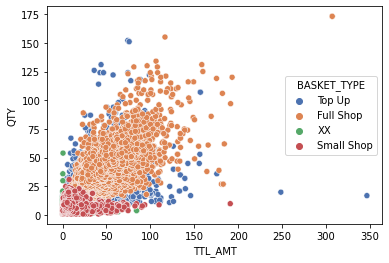

In [89]:
import seaborn as sns
sns.scatterplot(data=df_all_data, x="TTL_AMT", y="QTY", hue="BASKET_TYPE", palette="deep")
plt.savefig("SCATTER_OVERALL.png",format='png',dpi=150)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

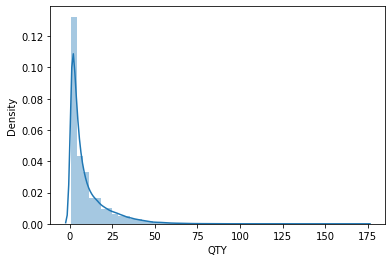

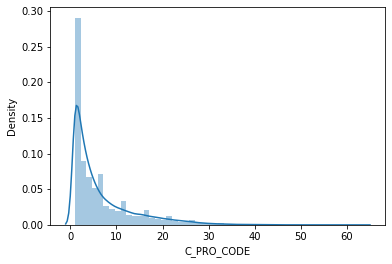

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_dist_bkt(df) :
  df_title = df["BASKET_TYPE"][0]
  print(f'-------------------------------------- {df_title} ------------------------------------------')
  for i, col in enumerate(df.columns[4:-6]):
      plt.figure(i)
      sns.distplot(df[col])
      
  plt.show()

# ls_df_bkt_plot = [df_basket_top,df_basket_full,df_basket_xx,df_basket_sml]
# for ii in ls_df_bkt_plot :
#   plot_dist_bkt(ii)
plt.figure("TTL_AMT")
sns.distplot(df_all_data["TTL_AMT"])
plt.figure("QTY")
sns.distplot(df_all_data["QTY"])
plt.figure("C_PRO_CODE")
sns.distplot(df_all_data["C_PRO_CODE"])

## **PREPARATION**

* ### **CREATE RATING : RECENCY**



> FOR  REPRESENT OVERVIEW OF CUSTOMER SPENDING



In [11]:
#CREATE R -> RECENCY
prep_for_recen = df_all_data[["CUST_CODE","SHOP_DATE"]].drop_duplicates(subset=["CUST_CODE","SHOP_DATE"])
prep_for_recen = prep_for_recen.sort_values(by=["CUST_CODE","SHOP_DATE"]).reset_index().drop("index",axis=1)

In [12]:
prep_for_recen["SHIFT_DATE"] = prep_for_recen["SHOP_DATE"].shift(1).fillna(0).astype(int)
prep_for_recen["CHECK_FIRST"] = prep_for_recen.duplicated("CUST_CODE")

In [13]:
prep_for_recen["LAG_SHOP_DATE"] = np.where(prep_for_recen["CHECK_FIRST"]==False , 0 , prep_for_recen["SHIFT_DATE"] )
prep_for_recen = prep_for_recen[prep_for_recen["LAG_SHOP_DATE"] > 0 ]

In [14]:
from datetime import datetime

def days_between(dd):
    d1 = datetime.strptime(str(dd["SHOP_DATE"]), "%Y%m%d")
    d2 = datetime.strptime(str(dd["SHIFT_DATE"]), "%Y%m%d")
    return abs((d2 - d1).days)
prep_for_recen["DATE_DIFF"] = prep_for_recen.apply(days_between,axis=1)

In [15]:
sc = StandardScaler()

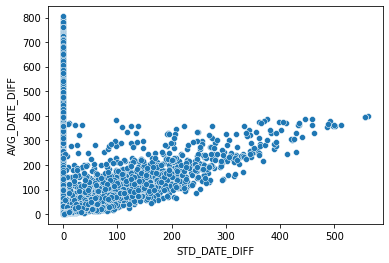

In [16]:
prep_for_recen_agg = prep_for_recen[["CUST_CODE","DATE_DIFF"]].groupby("CUST_CODE").mean().reset_index().rename({"DATE_DIFF":"AVG_DATE_DIFF"},axis=1)
prep_for_recen_agg["MED_DATE_DIFF"] = prep_for_recen[["CUST_CODE","DATE_DIFF"]].groupby("CUST_CODE").median().reset_index().rename({"DATE_DIFF":"MED_DATE_DIFF"},axis=1)[["MED_DATE_DIFF"]]
prep_for_recen_agg["STD_DATE_DIFF"] = prep_for_recen[["CUST_CODE","DATE_DIFF"]].groupby("CUST_CODE").std().reset_index().rename({"DATE_DIFF":"STD_DATE_DIFF"},axis=1)[["STD_DATE_DIFF"]]
prep_for_recen_agg = prep_for_recen_agg.fillna(0)
sns.scatterplot(data=prep_for_recen_agg, x="STD_DATE_DIFF", y="AVG_DATE_DIFF", palette="deep")

In [17]:
prep_for_recen_agg["SC_DATE_DIFF"] = sc.fit_transform(prep_for_recen_agg[["AVG_DATE_DIFF"]])
prep_for_recen_agg["CV_DATE_DIFF"] = prep_for_recen_agg["STD_DATE_DIFF"]/prep_for_recen_agg["AVG_DATE_DIFF"]
prep_for_recen_agg["SC_CV_DATE_DIFF"] = sc.fit_transform(prep_for_recen_agg[["CV_DATE_DIFF"]])

In [18]:
prep_for_recen_agg

CUST_CODE  AVG_DATE_DIFF  ...  CV_DATE_DIFF  SC_CV_DATE_DIFF
0     CUST0000000369       4.246073  ...      0.889355         0.058978
1     CUST0000000689      22.466667  ...      1.249451         0.578752
2     CUST0000000998      32.000000  ...      1.193243         0.497619
3     CUST0000001163     203.000000  ...      1.268040         0.605584
4     CUST0000001194       8.315789  ...      0.786846        -0.088986
...              ...            ...  ...           ...              ...
4052  CUST0000999569       8.000000  ...      4.199828         4.837421
4053  CUST0000999593      24.034483  ...      0.934567         0.124239
4054  CUST0000999645      73.900000  ...      1.864667         1.466775
4055  CUST0000999935      29.157895  ...      0.945149         0.139512
4056  CUST0000999936     124.600000  ...      1.044674         0.283171

[4057 rows x 7 columns]

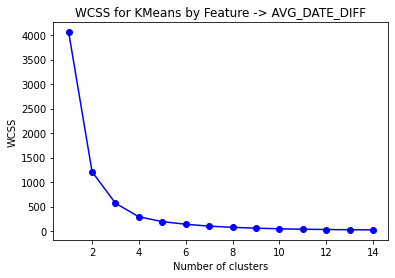

In [90]:
from sklearn.cluster import KMeans
# Use the Elbow method to find a good number of clusters using Within-Cluster-Sum-of-Squares (WCSS)
wcss = []
N = range(1, 15)
for i in N:
    kmeans = KMeans(n_clusters=i) 
    kmeans.fit_predict(prep_for_recen_agg[["SC_DATE_DIFF"]])
    wcss.append(kmeans.inertia_)
    
plt.plot(N, wcss, 'bo-')
plt.title("WCSS for KMeans by Feature -> AVG_DATE_DIFF")
plt.xlabel("Number of clusters")
plt.ylabel("WCSS")
plt.savefig("Elbow_recen.png",format='png',dpi=150)
plt.show()

In [20]:
#let's choose k = 5
cluster_r = KMeans(n_clusters=4,random_state=123)
prep_for_recen_agg['KCluster_Recen'] = cluster_r.fit_predict(prep_for_recen_agg[["SC_DATE_DIFF"]])

In [21]:
cluster_sum_recen = prep_for_recen_agg.groupby("KCluster_Recen").mean()
cluster_sum_recen["COUNT"] = prep_for_recen_agg[["CUST_CODE","KCluster_Recen"]].groupby("KCluster_Recen").count()
cluster_sum_recen
#ทำการแบ่งลักษณะลูกค้าออกเป็น 3 ระดับ คือ 
#Cluster 0,3,5,6 -> Good : กลุ่มลูกค้าชั้นดี มาใช้เฉลี่ยเดือนละครั้ง
#Cluster 2,7 -> Medium : กลุ่มลูกค้ากลางๆ 2-3 เดือนมาที มาซื้อของเข้าบ้าน
#Cluster 1,4 -> Bad : กลุ่มลูกค้าชั้นแย่ นานๆมาใช้ที

AVG_DATE_DIFF  MED_DATE_DIFF  ...  SC_CV_DATE_DIFF  COUNT
KCluster_Recen                                ...                        
0                  136.764146     112.774500  ...        -0.109702   1000
1                  314.377637     308.664557  ...        -0.628907    395
2                  609.073171     609.073171  ...        -1.224746    164
3                   30.928981      21.633707  ...         0.223771   2498

[4 rows x 7 columns]

In [22]:
prep_for_recen_agg["LABEL_RECEN"] = np.where(
    prep_for_recen_agg["KCluster_Recen"].isin([3]),"Montly",np.where(
        prep_for_recen_agg["KCluster_Recen"].isin([0]),"Quarterly" , np.where(
            prep_for_recen_agg["KCluster_Recen"].isin([1]),"Yearly" , "Outlier"
        )
        )
)

In [23]:
prep_for_recen_agg["RECEN_RATING"] = np.where(
    prep_for_recen_agg["KCluster_Recen"].isin([3]),5,np.where(
        prep_for_recen_agg["KCluster_Recen"].isin([0]),4 , np.where(
            prep_for_recen_agg["KCluster_Recen"].isin([1]),3 , 2
        )
        )
)

In [24]:
prep_for_recen_agg

CUST_CODE  AVG_DATE_DIFF  ...  LABEL_RECEN  RECEN_RATING
0     CUST0000000369       4.246073  ...       Montly             5
1     CUST0000000689      22.466667  ...       Montly             5
2     CUST0000000998      32.000000  ...       Montly             5
3     CUST0000001163     203.000000  ...    Quarterly             4
4     CUST0000001194       8.315789  ...       Montly             5
...              ...            ...  ...          ...           ...
4052  CUST0000999569       8.000000  ...       Montly             5
4053  CUST0000999593      24.034483  ...       Montly             5
4054  CUST0000999645      73.900000  ...       Montly             5
4055  CUST0000999935      29.157895  ...       Montly             5
4056  CUST0000999936     124.600000  ...    Quarterly             4

[4057 rows x 10 columns]

In [91]:
sns.scatterplot(data=prep_for_recen_agg, x="AVG_DATE_DIFF", y="CV_DATE_DIFF", hue="LABEL_RECEN", palette="deep")
plt.savefig("Distribution_Cls_Recen.png",format='png',dpi=150)

* ### **CREATE RATING : FREQUENCY OF C_PRODUCT**



> FOR  REPRESENT OVERVIEW OF CUSTOMER SPENDING



In [26]:
#CREATE F -> FREQUENCY
prep_for_freq = df_all_data[["CUST_CODE","BASKET_ID","C_PRO_CODE"]].drop_duplicates(subset=["CUST_CODE","BASKET_ID"])
prep_for_freq = prep_for_freq.sort_values(by=["CUST_CODE","BASKET_ID"]).reset_index().drop("index",axis=1)
prep_for_freq

CUST_CODE        BASKET_ID  C_PRO_CODE
0       CUST0000000181  994103900142002           1
1       CUST0000000369  994100100152797           4
2       CUST0000000369  994100200154676           4
3       CUST0000000369  994100300159851           3
4       CUST0000000369  994100400162425           1
...                ...              ...         ...
122173  CUST0000999936  994102400800273           1
122174  CUST0000999936  994105000808949           3
122175  CUST0000999936  994105700802599           6
122176  CUST0000999936  994110400741944           3
122177  CUST0000999936  994110600817658           1

[122178 rows x 3 columns]

In [27]:
prep_for_freq_agg = prep_for_freq[["CUST_CODE","C_PRO_CODE"]].groupby("CUST_CODE").mean().reset_index().rename({"C_PRO_CODE":"AVG_C_PRO_CODE"},axis=1)
prep_for_freq_agg["MED_C_PRO_CODE"] = prep_for_freq[["CUST_CODE","C_PRO_CODE"]].groupby("CUST_CODE").median().reset_index().rename({"C_PRO_CODE":"MED_C_PRO_CODE"},axis=1)[["MED_C_PRO_CODE"]]
prep_for_freq_agg["STD_C_PRO_CODE"] = prep_for_freq[["CUST_CODE","C_PRO_CODE"]].groupby("CUST_CODE").std().reset_index().rename({"C_PRO_CODE":"STD_C_PRO_CODE"},axis=1)[["STD_C_PRO_CODE"]]
prep_for_freq_agg = prep_for_freq_agg.fillna(0)
sns.scatterplot(data=prep_for_freq_agg, x="STD_C_PRO_CODE", y="AVG_C_PRO_CODE", palette="deep")

In [28]:
prep_for_freq_agg["SC_C_PRO_CODE"] = sc.fit_transform(prep_for_freq_agg[["AVG_C_PRO_CODE"]])
prep_for_freq_agg["CV_C_PRO_CODE"] = prep_for_freq_agg["STD_C_PRO_CODE"]/prep_for_freq_agg["AVG_C_PRO_CODE"]
prep_for_freq_agg["SC_CV_C_PRO_CODE"] = sc.fit_transform(prep_for_freq_agg[["CV_C_PRO_CODE"]])

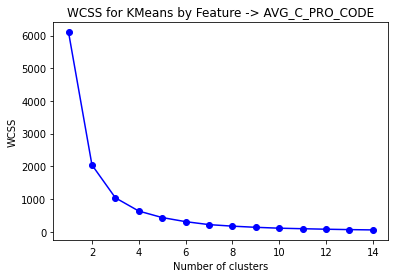

In [92]:
from sklearn.cluster import KMeans
# Use the Elbow method to find a good number of clusters using Within-Cluster-Sum-of-Squares (WCSS)
wcss = []
N = range(1, 15)
for i in N:
    kmeans = KMeans(n_clusters=i) 
    kmeans.fit_predict(prep_for_freq_agg[["SC_C_PRO_CODE"]])
    wcss.append(kmeans.inertia_)
    
plt.plot(N, wcss, 'bo-')
plt.title("WCSS for KMeans by Feature -> AVG_C_PRO_CODE")
plt.xlabel("Number of clusters")
plt.ylabel("WCSS")
plt.savefig("Elbow_freq.png",format='png',dpi=150)
plt.show()

In [30]:
#let's choose k = 5
cluster_f = KMeans(n_clusters=5,random_state=123)
prep_for_freq_agg['KCluster_Freq'] = cluster_f.fit_predict(prep_for_freq_agg[["SC_C_PRO_CODE"]])

In [31]:
cluster_sum_freq = prep_for_freq_agg.groupby("KCluster_Freq").mean()
cluster_sum_freq["COUNT"] = prep_for_freq_agg[["CUST_CODE","KCluster_Freq"]].groupby("KCluster_Freq").count()
cluster_sum_freq
#ทำการแบ่งลักษณะลูกค้าออกเป็น 3 ระดับ คือ 
#Cluster 2 -> Low : ซื้อครั้งนึงไม่กี่ประเภทสินค้า
#Cluster 0 -> Medium : ซื้อระดับกลางๆ 
#Cluster 1,4,3 -> High : ซื้่อที่หลายประเภทมาก

AVG_C_PRO_CODE  MED_C_PRO_CODE  ...  SC_CV_C_PRO_CODE  COUNT
KCluster_Freq                                  ...                         
0                    5.358220        4.576482  ...          0.563722   1484
1                   18.016587       18.284722  ...         -0.015802    360
2                    1.769714        1.646035  ...         -0.353039   3304
3                   10.492698        9.633939  ...          0.435862    881
4                   30.547909       30.683099  ...         -0.682102     71

[5 rows x 7 columns]

In [32]:
prep_for_freq_agg["LABEL_FREQ"] = np.where(
    prep_for_freq_agg["KCluster_Freq"].isin([2]),"Low",np.where(
        prep_for_freq_agg["KCluster_Freq"].isin([1,4,3]),"High" , "Medium"
        )
)

In [33]:
prep_for_freq_agg["FREQ_RATING"] = np.where(
    prep_for_freq_agg["KCluster_Freq"].isin([2]),1,np.where(
        prep_for_freq_agg["KCluster_Freq"].isin([1,4,3]),3 , 2
        )
)

In [34]:
prep_for_freq_agg

CUST_CODE  AVG_C_PRO_CODE  ...  LABEL_FREQ  FREQ_RATING
0     CUST0000000181        1.000000  ...         Low            1
1     CUST0000000369        3.177273  ...         Low            1
2     CUST0000000689       11.562500  ...        High            3
3     CUST0000000998        1.333333  ...         Low            1
4     CUST0000001163        6.250000  ...      Medium            2
...              ...             ...  ...         ...          ...
6095  CUST0000999593        9.900000  ...        High            3
6096  CUST0000999645        5.454545  ...      Medium            2
6097  CUST0000999654        4.000000  ...      Medium            2
6098  CUST0000999935       11.238095  ...        High            3
6099  CUST0000999936        2.500000  ...         Low            1

[6100 rows x 10 columns]

* ### **CREATE RATING : MONE OF TICKET_SIZE**



> FOR  REPRESENT OVERVIEW OF CUSTOMER SPENDING



In [35]:
#CREATE M -> MONETARY
prep_for_mone = df_all_data[["CUST_CODE","BASKET_ID","TTL_AMT"]].drop_duplicates(subset=["CUST_CODE","BASKET_ID"])
prep_for_mone = prep_for_mone.sort_values(by=["CUST_CODE","BASKET_ID"]).reset_index().drop("index",axis=1)
prep_for_mone

CUST_CODE        BASKET_ID  TTL_AMT
0       CUST0000000181  994103900142002     2.44
1       CUST0000000369  994100100152797     5.77
2       CUST0000000369  994100200154676     2.91
3       CUST0000000369  994100300159851    11.96
4       CUST0000000369  994100400162425     0.86
...                ...              ...      ...
122173  CUST0000999936  994102400800273     1.88
122174  CUST0000999936  994105000808949     6.11
122175  CUST0000999936  994105700802599     5.80
122176  CUST0000999936  994110400741944     1.92
122177  CUST0000999936  994110600817658     0.98

[122178 rows x 3 columns]

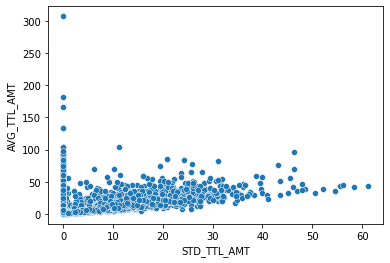

In [36]:
prep_for_mone_agg = prep_for_mone[["CUST_CODE","TTL_AMT"]].groupby("CUST_CODE").mean().reset_index().rename({"TTL_AMT":"AVG_TTL_AMT"},axis=1)
prep_for_mone_agg["MED_TTL_AMT"] = prep_for_mone[["CUST_CODE","TTL_AMT"]].groupby("CUST_CODE").median().reset_index().rename({"TTL_AMT":"MED_TTL_AMT"},axis=1)[["MED_TTL_AMT"]]
prep_for_mone_agg["STD_TTL_AMT"] = prep_for_mone[["CUST_CODE","TTL_AMT"]].groupby("CUST_CODE").std().reset_index().rename({"TTL_AMT":"STD_TTL_AMT"},axis=1)[["STD_TTL_AMT"]]
prep_for_mone_agg = prep_for_mone_agg.fillna(0)
sns.scatterplot(data=prep_for_mone_agg, x="STD_TTL_AMT", y="AVG_TTL_AMT", palette="deep")

In [37]:
prep_for_mone_agg["CV_AMT"] = prep_for_mone_agg["STD_TTL_AMT"]/prep_for_mone_agg["AVG_TTL_AMT"]
prep_for_mone_agg["SC_TK_SIZE"] = sc.fit_transform(prep_for_mone_agg[["AVG_TTL_AMT"]])

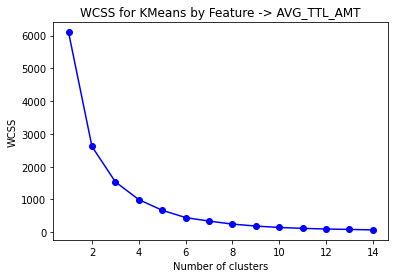

In [93]:
from sklearn.cluster import KMeans
# Use the Elbow method to find a good number of clusters using Within-Cluster-Sum-of-Squares (WCSS)
wcss = []
N = range(1, 15)
for i in N:
    kmeans = KMeans(n_clusters=i) 
    kmeans.fit_predict(prep_for_mone_agg[["SC_TK_SIZE"]])
    wcss.append(kmeans.inertia_)
    
plt.plot(N, wcss, 'bo-')
plt.title("WCSS for KMeans by Feature -> AVG_TTL_AMT")
plt.xlabel("Number of clusters")
plt.ylabel("WCSS")
plt.savefig("Elbow_mone.png",format='png',dpi=150)
plt.show()

In [39]:
#let's choose k = 5
cluster_m = KMeans(n_clusters=5,random_state=123)
prep_for_mone_agg['KCluster_Mone'] = cluster_m.fit_predict(prep_for_mone_agg[["SC_TK_SIZE"]])

In [40]:
cluster_sum_mone = prep_for_mone_agg.groupby("KCluster_Mone").mean()
cluster_sum_mone["COUNT"] = prep_for_mone_agg[["CUST_CODE","KCluster_Mone"]].groupby("KCluster_Mone").count()
cluster_sum_mone.sort_values(by=["AVG_TTL_AMT"])
#ทำการแบ่งลักษณะลูกค้าออกเป็น 3 ระดับ คือ 
#Cluster 0 -> Low 
#Cluster 2 -> Medium 
#Cluster 1 -> Moderate 
#Cluster 3 -> High 
#Cluster 4 -> Extra 

AVG_TTL_AMT  MED_TTL_AMT  ...  SC_TK_SIZE  COUNT
KCluster_Mone                            ...                   
0                 3.415566     2.973378  ...   -0.506372   3902
2                14.990231    12.925824  ...    0.369540   1566
1                33.185787    31.968075  ...    1.746486    535
3                67.110786    66.992989  ...    4.313757     92
4               184.348000   184.348000  ...   13.185671      5

[5 rows x 6 columns]

In [41]:
prep_for_mone_agg["LABEL_MONE"] = np.where(
    prep_for_mone_agg["KCluster_Mone"].isin([0]),"Low",np.where(
        prep_for_mone_agg["KCluster_Mone"].isin([2]),"Medium" , np.where(
            prep_for_mone_agg["KCluster_Mone"].isin([1]),"Moderate" , np.where(
                prep_for_mone_agg["KCluster_Mone"].isin([3]),"High" , "Extra"
                )
            )
        )
        )

In [42]:
prep_for_mone_agg["MONE_RATING"] = np.where(
    prep_for_mone_agg["KCluster_Mone"].isin([0]),1,np.where(
        prep_for_mone_agg["KCluster_Mone"].isin([2]),2 , np.where(
            prep_for_mone_agg["KCluster_Mone"].isin([1]),3 , np.where(
                prep_for_mone_agg["KCluster_Mone"].isin([3]),4 , 5
                )
            )
        )
        )

In [43]:
prep_for_mone_agg

CUST_CODE  AVG_TTL_AMT  ...  LABEL_MONE  MONE_RATING
0     CUST0000000181     2.440000  ...         Low            1
1     CUST0000000369     4.360591  ...         Low            1
2     CUST0000000689    20.535625  ...      Medium            2
3     CUST0000000998     1.983333  ...         Low            1
4     CUST0000001163     9.935000  ...      Medium            2
...              ...          ...  ...         ...          ...
6095  CUST0000999593    15.119333  ...      Medium            2
6096  CUST0000999645     9.555455  ...      Medium            2
6097  CUST0000999654     5.860000  ...         Low            1
6098  CUST0000999935    21.150952  ...      Medium            2
6099  CUST0000999936     2.945000  ...         Low            1

[6100 rows x 9 columns]

In [44]:
prep_for_mone_agg.columns

Index(['CUST_CODE', 'AVG_TTL_AMT', 'MED_TTL_AMT', 'STD_TTL_AMT', 'CV_AMT',
       'SC_TK_SIZE', 'KCluster_Mone', 'LABEL_MONE', 'MONE_RATING'],
      dtype='object')

In [45]:
# COMBINATION ALL GROUP
df_recen_ok = prep_for_recen_agg[["CUST_CODE","AVG_DATE_DIFF","MED_DATE_DIFF","STD_DATE_DIFF","CV_DATE_DIFF","LABEL_RECEN","RECEN_RATING"]]
df_freq_ok = prep_for_freq_agg[["CUST_CODE",'AVG_C_PRO_CODE', 'MED_C_PRO_CODE', 'STD_C_PRO_CODE', 'CV_C_PRO_CODE',"LABEL_FREQ","FREQ_RATING"]]
df_mone_ok = prep_for_mone_agg[["CUST_CODE",'AVG_TTL_AMT', 'MED_TTL_AMT', 'STD_TTL_AMT', 'CV_AMT',"LABEL_MONE","MONE_RATING"]]

In [46]:
data_frames = [df_mone_ok, df_freq_ok, df_recen_ok]
df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['CUST_CODE'],
                                            how='outer'), data_frames).fillna(0)
df_merged["LABEL_RECEN"] =np.where(df_merged["LABEL_RECEN"]==0,"Come once",df_merged["LABEL_RECEN"])
df_merged["RECEN_RATING"] =np.where(df_merged["LABEL_RECEN"]=="Come once",1,df_merged["RECEN_RATING"]).astype(int)

In [47]:
df_merged_top = df_merged[(df_merged["RECEN_RATING"] == 5) & (df_merged["FREQ_RATING"] >= 2) & (df_merged["MONE_RATING"] >= 3) ]
df_merged_con = df_merged.drop(df_merged_top.index,axis=0)

In [48]:
# df_merged_con.groupby(["RECEN_RATING","FREQ_RATING","MONE_RATING"]).count().reset_index().sort_values(by=["CUST_CODE"],ascending = False)

In [94]:
df_merged[["CUST_CODE","RECEN_RATING","FREQ_RATING","MONE_RATING"]]

CUST_CODE  RECEN_RATING  FREQ_RATING  MONE_RATING
0     CUST0000000181             1            1            1
1     CUST0000000369             5            1            1
2     CUST0000000689             5            3            2
3     CUST0000000998             5            1            1
4     CUST0000001163             4            2            2
...              ...           ...          ...          ...
6095  CUST0000999593             5            3            2
6096  CUST0000999645             5            2            2
6097  CUST0000999654             1            2            1
6098  CUST0000999935             5            3            2
6099  CUST0000999936             4            1            1

[6100 rows x 4 columns]

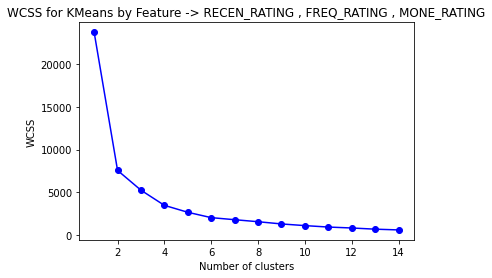

In [95]:
from sklearn.cluster import KMeans
# Use the Elbow method to find a good number of clusters using Within-Cluster-Sum-of-Squares (WCSS)
wcss = []
N = range(1, 15)
for i in N:
    kmeans = KMeans(n_clusters=i) 
    kmeans.fit_predict(df_merged_con[["RECEN_RATING","FREQ_RATING","MONE_RATING"]])
    wcss.append(kmeans.inertia_)
    
plt.plot(N, wcss, 'bo-')
plt.title("WCSS for KMeans by Feature -> RECEN_RATING , FREQ_RATING , MONE_RATING")
plt.xlabel("Number of clusters")
plt.ylabel("WCSS")
plt.savefig("Elbow_cluster_all.png",format='png',dpi=150)
plt.show()

In [51]:
#let's choose k = 5
cluster_all = KMeans(n_clusters=5,random_state=123)
df_merged_con['KCluster_All'] = cluster_all.fit_predict(df_merged_con[["RECEN_RATING","FREQ_RATING","MONE_RATING"]])

In [52]:
df_merged_con[df_merged_con["KCluster_All"] == 3].groupby("LABEL_RECEN").count()

CUST_CODE  AVG_TTL_AMT  ...  RECEN_RATING  KCluster_All
LABEL_RECEN                          ...                            
Come once          458          458  ...           458           458
Outlier             35           35  ...            35            35
Yearly               6            6  ...             6             6

[3 rows x 19 columns]

In [53]:
df_merged_con[df_merged_con["KCluster_All"] == 2]

CUST_CODE  AVG_TTL_AMT  ...  RECEN_RATING  KCluster_All
8     CUST0000002605     0.300000  ...             4             2
14    CUST0000003252     1.915000  ...             4             2
16    CUST0000003323     3.155000  ...             3             2
21    CUST0000005053     2.747500  ...             4             2
24    CUST0000005207     3.970000  ...             4             2
...              ...          ...  ...           ...           ...
6069  CUST0000996827     1.630000  ...             4             2
6083  CUST0000998052     9.320000  ...             4             2
6088  CUST0000998703     0.941111  ...             4             2
6092  CUST0000999439     4.360000  ...             4             2
6099  CUST0000999936     2.945000  ...             4             2

[990 rows x 20 columns]

In [54]:
cluster_sum_all = df_merged_con.groupby("KCluster_All").mean()
cluster_sum_all["COUNT"] = df_merged_con[["CUST_CODE","KCluster_All"]].groupby("KCluster_All").count()
cluster_sum_all[["RECEN_RATING","FREQ_RATING","MONE_RATING","AVG_DATE_DIFF","AVG_C_PRO_CODE","AVG_TTL_AMT","COUNT"]].sort_values(by=["RECEN_RATING"])
#ทำการแบ่งลักษณะลูกค้าออกเป็น 3 ระดับ คือ 
#Cluster 1,3 -> Low Active | เป็นกลุ่มลูกค้าที่ไม่ค่อยมาซื้อซักเท่าไหร่ มาแล้วหาย หรือ พึ่งมา หรือ มาแล้วนานมากกว่าจะกลับมาอีก  
#Cluster 2 -> Occational | มาใช้บ้างประปราย แต่ก็ไม่ได้ใช้เยอะแยะอะไร อาจจะไม่ได้มีสินค้าดนใจให้เข้ามาบ่อยๆ แต่ก็เข้ามาซื้อบ้าง 
#Cluster 0 -> Promising  | แววดี ถ้าเข้าไป Boost กับกลุ่มลูกค้าเหล่านี้อาจจะกลายเป็นลูกค้าชั้นดีกับเราได้เลย
#Cluster 4 -> General | กลุ่มลูกค้าทั่วไป มาใช้บ่อยแต่ไม่ได้ใช้เยอะแยะอะไร 

RECEN_RATING  FREQ_RATING  ...  AVG_TTL_AMT  COUNT
KCluster_All                             ...                    
1                 1.075263     1.112602  ...     2.876880   1714
3                 1.094188     2.673347  ...    28.634262    499
2                 3.675758     1.173737  ...     4.053824    990
0                 4.626101     2.530024  ...    17.269208   1249
4                 5.000000     1.298441  ...     4.740764   1347

[5 rows x 7 columns]

In [55]:
df_merged_con["LABEL_CUST"] = np.where(
    df_merged_con["KCluster_All"].isin([1,3]),"Low Active",np.where(
        df_merged_con["KCluster_All"].isin([2]),"Occational" , np.where(
            df_merged_con["KCluster_All"].isin([0]),"Potential" , "General"
            )
        )
        )

In [56]:
df_merged_top["LABEL_CUST"] = "Loyal"
df_merged_top["KCluster_All"] = 99

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [57]:
df_cluster_ok = pd.concat([df_merged_top,df_merged_con],axis=0)

In [58]:
df_cluster_ok["Kmns_Cluster_Cust"] = np.where(
    df_cluster_ok["LABEL_CUST"] == "Low Active", 1 ,np.where(
        df_cluster_ok["LABEL_CUST"] == "Occational", 2 ,np.where(
            df_cluster_ok["LABEL_CUST"] == "General", 3 ,np.where(
                df_cluster_ok["LABEL_CUST"] == "Potential", 4 , 5
            )
        )
    )

)

In [59]:
df_cluster_ok.head(5)

CUST_CODE  AVG_TTL_AMT  ...  KCluster_All  Kmns_Cluster_Cust
5   CUST0000001194    24.211942  ...            99                  5
39  CUST0000007860    55.647045  ...            99                  5
57  CUST0000011202   104.250000  ...            99                  5
66  CUST0000012784    41.879231  ...            99                  5
83  CUST0000017629    35.955806  ...            99                  5

[5 rows x 22 columns]

In [60]:
df_cluster_ok[['LABEL_CUST','CUST_CODE']].groupby('LABEL_CUST').count()

CUST_CODE
LABEL_CUST           
General          1347
Low Active       2213
Loyal             301
Occational        990
Potential        1249

In [61]:
dfCluster_kiki = df_cluster_ok.groupby('LABEL_CUST').mean()
dfCluster_kiki['NO_CUST'] = df_cluster_ok[['LABEL_CUST','CUST_CODE']].groupby('LABEL_CUST').count()

dfCluster = dfCluster_kiki.reset_index()
dfCluster

LABEL_CUST  AVG_TTL_AMT  ...  Kmns_Cluster_Cust  NO_CUST
0     General     4.740764  ...                3.0     1347
1  Low Active     8.684803  ...                1.0     2213
2       Loyal    34.766665  ...                5.0      301
3  Occational     4.053824  ...                2.0      990
4   Potential    17.269208  ...                4.0     1249

[5 rows x 19 columns]

<Figure size 432x288 with 0 Axes>

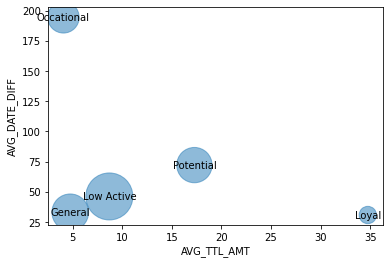

In [87]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure()
fig, ax = plt.subplots()
ax.scatter(dfCluster['AVG_TTL_AMT'], dfCluster['AVG_DATE_DIFF'], s=dfCluster['NO_CUST'], alpha = 0.5)
ax.set_xlabel("AVG_TTL_AMT")
ax.set_ylabel("AVG_DATE_DIFF")

for i, txt in enumerate(dfCluster['LABEL_CUST']):
  ax.annotate(txt, (dfCluster['AVG_TTL_AMT'][i], dfCluster["AVG_DATE_DIFF"][i]), horizontalalignment='center', verticalalignment='center')

plt.savefig("Bubble_Cluster.png",format='png',dpi=150)
plt.show()


In [63]:
plt.figure(figsize=(20,8))
sns.heatmap(dfCluster_kiki[["RECEN_RATING","FREQ_RATING","MONE_RATING"]].sort_values(by=["RECEN_RATING"]),
            cmap="RdYlGn",annot=True,
            linewidths=.1
            )
plt.tight_layout()
plt.savefig("Heat_Map_Cluster.png",format='png',dpi=150)

In [64]:
# TYPE TOP
recheck_top = df_basket_top[["CUST_CODE","BASKET_TYPE"]].drop_duplicates().merge(df_cluster_ok,how="left",on="CUST_CODE")[["CUST_CODE","BASKET_TYPE","LABEL_CUST"]]
recheck_top = recheck_top.groupby("LABEL_CUST").count()

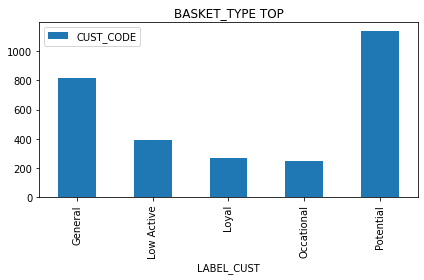

In [100]:
recheck_top.reset_index().plot.bar(x="LABEL_CUST",y="CUST_CODE")
plt.title("BASKET_TYPE TOP")
plt.tight_layout()
plt.savefig("bar_count_top.png",format='png',dpi=150)

In [66]:
# TYPE FULL
recheck_full = df_basket_full[["CUST_CODE","BASKET_TYPE"]].drop_duplicates().merge(df_cluster_ok,how="left",on="CUST_CODE")[["CUST_CODE","BASKET_TYPE","LABEL_CUST"]]
recheck_full = recheck_full.groupby("LABEL_CUST").count()

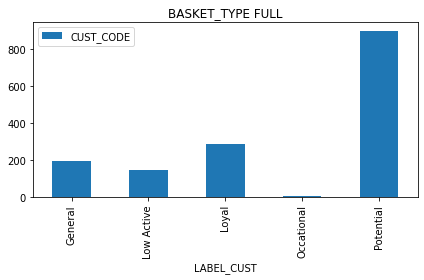

In [101]:
recheck_full.reset_index().plot.bar(x="LABEL_CUST",y="CUST_CODE")
plt.title("BASKET_TYPE FULL")
plt.tight_layout()
plt.savefig("bar_count_full.png",format='png',dpi=150)

In [68]:
# TYPE XX
recheck_xx = df_basket_xx[["CUST_CODE","BASKET_TYPE"]].drop_duplicates().merge(df_cluster_ok,how="left",on="CUST_CODE")[["CUST_CODE","BASKET_TYPE","LABEL_CUST"]]
recheck_xx = recheck_xx.groupby("LABEL_CUST").count()

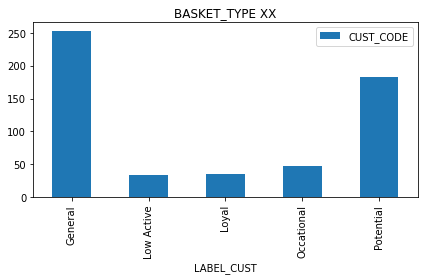

In [102]:
recheck_xx.reset_index().plot.bar(x="LABEL_CUST",y="CUST_CODE")
plt.title("BASKET_TYPE XX")
plt.tight_layout()
plt.savefig("bar_count_xx.png",format='png',dpi=150)

In [70]:
# TYPE SML
recheck_sml = df_basket_sml[["CUST_CODE","BASKET_TYPE"]].drop_duplicates().merge(df_cluster_ok,how="left",on="CUST_CODE")[["CUST_CODE","BASKET_TYPE","LABEL_CUST"]]
recheck_sml = recheck_sml.groupby("LABEL_CUST").count()

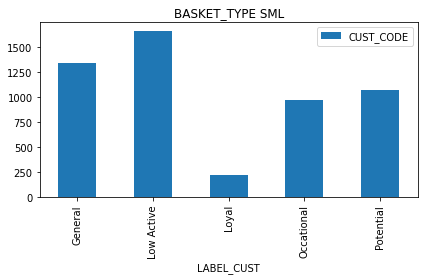

In [103]:
recheck_sml.reset_index().plot.bar(x="LABEL_CUST",y="CUST_CODE")
plt.title("BASKET_TYPE SML")
plt.tight_layout()
plt.savefig("bar_count_sml.png",format='png',dpi=150)

## **PREPARATION : OVERVIEW ALL COMPARE PORT**

In [72]:
sql_summary = '''
SELECT * FROM `windy-ripsaw-309202.DATA_FOR_CLUSTER.SUM_TXN_DATA`
'''
df_summary_prep = pd.io.gbq.read_gbq(sql_summary , project_id=project_id, verbose=False, dialect="standard")

### **PER DAY**

In [73]:
q2_query = """
SELECT
CUSTOMER_NO as CUST_CODE , 
PIR_PURCH_DT as SHOP_DATE ,
AVG(C_PROD_CODE) as AVG_C_PROD_CODE_DAY ,
SUM(QUANTITY) as AVG_QTY_DAY ,
SUM(AMT) as AVG_SPEDING_DAY 
FROM df_summary_prep
group by CUST_CODE , PIR_PURCH_DT
;
"""
df_overview_day  = pysqldf(q2_query)

NameError: ignored

In [ ]:
df_overview_day_mean = df_overview_day.groupby("CUST_CODE").mean().reset_index().rename({"index":"CUST_CODE"},axis=1).drop("SHOP_DATE",axis=1)
df_overview_day_std = df_overview_day.groupby("CUST_CODE").std().reset_index().rename({
    "index":"CUST_CODE",
    "AVG_C_PROD_CODE_DAY" : "STD_C_PROD_CODE_DAY" ,
    "AVG_QTY_DAY" : "STD_QTY_DAY" ,
    "AVG_SPEDING_DAY" : "STD_SPEDING_DAY"
    },axis=1).drop("SHOP_DATE",axis=1)

In [ ]:
df_overview_day_ok = df_overview_day_mean.merge(df_overview_day_std,how="left",on="CUST_CODE").fillna(0)
df_overview_day_ok.head(5)

### **PER MTH**

In [ ]:
q3_query = """
SELECT
CUSTOMER_NO as CUST_CODE , 
SUBSTR(PIR_PURCH_DT,1,6) as YYMM_MTH ,
AVG(C_PROD_CODE) as AVG_C_PROD_CODE_MTH ,
SUM(QUANTITY) as AVG_QTY_MTH ,
SUM(AMT) as AVG_SPENDING_MTH 
FROM df_summary_prep
group by CUST_CODE , SUBSTR(PIR_PURCH_DT,1,6)
;
"""
df_overview_mth  = pysqldf(q3_query)

In [ ]:
df_overview_mth

In [ ]:
df_overview_mth_mean = df_overview_mth.groupby("CUST_CODE").mean().reset_index().rename({"index":"CUST_CODE"},axis=1)
df_overview_mth_std = df_overview_mth.groupby("CUST_CODE").std().reset_index().rename({
    "index":"CUST_CODE",
    "AVG_C_PROD_CODE_MTH" : "STD_C_PROD_CODE_MTH" ,
    "AVG_QTY_MTH" : "STD_QTY_MTH" ,
    "AVG_SPENDING_MTH" : "STD_SPENDING_MTH"
    },axis=1)

In [ ]:
df_overview_mth_ok = df_overview_mth_mean.merge(df_overview_mth_std,how="left",on="CUST_CODE").fillna(0)
df_overview_mth_ok.head(5)

### **PER TXN**

In [ ]:
df_overview_txn = df_summary_prep[["CUSTOMER_NO","C_PROD_CODE","QUANTITY","AMT"]]

In [ ]:
df_overview_txn_mean = df_overview_txn.groupby("CUSTOMER_NO").mean().reset_index().rename({
    "index":"CUST_CODE",
    "CUSTOMER_NO":"CUST_CODE",
    "C_PROD_CODE":"C_PROD_CODE_TXN",
    "QUANTITY" : "QTY_TXN" ,
    "AMT" : "TK_SIZE"
    },axis=1)
df_overview_txn_std = df_overview_txn.groupby("CUSTOMER_NO").std().reset_index().rename({
    "index":"CUST_CODE",
    "CUSTOMER_NO":"CUST_CODE",
    "C_PROD_CODE" : "STD_C_PROD_CODE_TXN" ,
    "QUANTITY" : "STD_QTY_TXN" ,
    "AMT" : "STD_TK_SIZE"
    },axis=1)

In [ ]:
df_overview_txn_ok = df_overview_txn_mean.merge(df_overview_txn_std,how="left",on="CUST_CODE").fillna(0)
df_overview_txn_ok.head(5)

### **FUSION DATA**

In [ ]:
cust_code_key_ovv = list(set([j for i in [df_overview_txn_ok,df_overview_day_ok,df_overview_mth_ok] for j in i["CUST_CODE"].tolist()]))
cust_code_key_ovv.sort()
data_super_main_ovv = pd.DataFrame({"CUST_CODE":cust_code_key_ovv})
data_frames_ovv = [df_overview_txn_ok,df_overview_day_ok,df_overview_mth_ok]
df_merged_ovv = reduce(lambda  left,right: pd.merge(left,right,on=['CUST_CODE'],
                                            how='outer'), data_frames_ovv)

In [ ]:
df_preb_ok = df_merged_ovv.merge(df_merged_ok,how="left",on="CUST_CODE")
df_preb_ok.shape

In [ ]:
df_preb_ok

In [ ]:
# # ANOVA - TEST FOR SELECT VARIABLE
# ls_col_test_all = df_preb_ok.columns[1:]
# for i in ls_col_test_all :
#   print("####################################" + i + "#####################################")
#   print()
#   model = ols(i+' ~ C(BASKET_TYPE)', data=df_preb_ok).fit()
#   anova_table = sm.stats.anova_lm(model, typ=2)
#   print(anova_table)
#   print()

## **MODEL : CLUSTERING , RANDOM FOREST**

In [ ]:
from sklearn.preprocessing import StandardScaler

df_std = pd.DataFrame(StandardScaler().fit_transform(df_preb_ok[df_preb_ok.columns[1:]]))
df_std.head(5)

In [ ]:
from sklearn.cluster import KMeans
# Use the Elbow method to find a good number of clusters using Within-Cluster-Sum-of-Squares (WCSS)
wcss = []
N = range(1, 15)
for i in N:
    kmeans = KMeans(n_clusters=i) 
    kmeans.fit_predict(df_std)
    wcss.append(kmeans.inertia_)
    
plt.plot(N, wcss, 'bo-')
plt.title("Computing Within-Cluster-Sum-of-Squares (WCSS) for KMeans++")
plt.xlabel("Number of clusters")
plt.ylabel("WCSS")
plt.show()

In [ ]:
#let's choose k = 7
cluster = KMeans(n_clusters=7)
df_preb_ok['cluster'] = cluster.fit_predict(df_std)

In [ ]:
dfCluster = df_preb_ok.groupby('cluster', as_index=False).mean()
dfCluster['NO_CUST'] = df_preb_ok[['cluster','CUST_CODE']].groupby('cluster').count()

dfCluster

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure()
fig, ax = plt.subplots()
ax.scatter(dfCluster['TK_SIZE'], dfCluster['QTY_TXN'], s=dfCluster['NO_CUST'], alpha = 0.5)
ax.set_xlabel("TK_SIZE")
ax.set_ylabel("QTY_TXN")

for i, txt in enumerate(dfCluster['cluster']):
  ax.annotate(txt, (dfCluster['TK_SIZE'][i], dfCluster["QTY_TXN"][i]), horizontalalignment='center', verticalalignment='center')

plt.show()

In [ ]:
for i, col in enumerate(df_preb_ok.columns[1:-1]):
    sns.boxplot(x="cluster", y =col, data=df_preb_ok)
    plt.show()

In [ ]:
df_preb_ok.head(2)

In [ ]:
# ANOVA - TEST FOR SELECT VARIABLE
ls_col_test_all = df_preb_ok.columns[1:]
for i in ls_col_test_all :
  print("####################################" + i + "#####################################")
  print()
  model = ols(i+' ~ C(cluster)', data=df_preb_ok).fit()
  anova_table = sm.stats.anova_lm(model, typ=2)
  # if anova_table[["PR(>F)"]].iloc[0,0] >= 0.5 :
  print(anova_table[["PR(>F)"]].iloc[0,0])
  print()

## **RANDOM FOREST**

In [74]:
df_cluster_ok.columns

Index(['CUST_CODE', 'AVG_TTL_AMT', 'MED_TTL_AMT', 'STD_TTL_AMT', 'CV_AMT',
       'LABEL_MONE', 'MONE_RATING', 'AVG_C_PRO_CODE', 'MED_C_PRO_CODE',
       'STD_C_PRO_CODE', 'CV_C_PRO_CODE', 'LABEL_FREQ', 'FREQ_RATING',
       'AVG_DATE_DIFF', 'MED_DATE_DIFF', 'STD_DATE_DIFF', 'CV_DATE_DIFF',
       'LABEL_RECEN', 'RECEN_RATING', 'LABEL_CUST', 'KCluster_All',
       'Kmns_Cluster_Cust'],
      dtype='object')

In [75]:
from sklearn.ensemble import RandomForestClassifier

predictors = df_cluster_ok.drop(["LABEL_MONE","LABEL_RECEN","LABEL_FREQ"],axis=1).iloc[:,1:-3]
targets = df_cluster_ok.iloc[:,-1:]

scaler = StandardScaler()
predictors_scaled = scaler.fit_transform(predictors)

classifier = RandomForestClassifier(n_estimators = 50, criterion = 'entropy', random_state = 123 )
classifier.fit(predictors_scaled, targets.values.ravel())


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=123,
                       verbose=0, warm_start=False)

In [76]:
importances = list(classifier.feature_importances_)

feature_list = list(predictors.columns)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: RECEN_RATING         Importance: 0.19
Variable: AVG_DATE_DIFF        Importance: 0.17
Variable: AVG_TTL_AMT          Importance: 0.11
Variable: MONE_RATING          Importance: 0.11
Variable: MED_DATE_DIFF        Importance: 0.11
Variable: STD_TTL_AMT          Importance: 0.06
Variable: CV_AMT               Importance: 0.05
Variable: AVG_C_PRO_CODE       Importance: 0.04
Variable: STD_C_PRO_CODE       Importance: 0.04
Variable: STD_DATE_DIFF        Importance: 0.03
Variable: MED_TTL_AMT          Importance: 0.02
Variable: CV_C_PRO_CODE        Importance: 0.02
Variable: FREQ_RATING          Importance: 0.02
Variable: CV_DATE_DIFF         Importance: 0.02
Variable: MED_C_PRO_CODE       Importance: 0.01


In [77]:
select_feature = [i[0] for i in feature_importances if i[1] >= 0.10]
select_feature.remove("MED_DATE_DIFF")

In [78]:
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn import tree
predictors_dcs_tree = df_cluster_ok[select_feature]
targets_dcs_tree= df_cluster_ok.iloc[:,-1:]

In [79]:
targets_dcs_tree["Focus_Cls1"] = np.where(targets_dcs_tree["Kmns_Cluster_Cust"] == 1 , 1 , 0)
targets_dcs_tree["Focus_Cls2"] = np.where(targets_dcs_tree["Kmns_Cluster_Cust"] == 2 , 1 , 0)
targets_dcs_tree["Focus_Cls3"] = np.where(targets_dcs_tree["Kmns_Cluster_Cust"] == 3 , 1 , 0)
targets_dcs_tree["Focus_Cls4"] = np.where(targets_dcs_tree["Kmns_Cluster_Cust"] == 4 , 1 , 0)
targets_dcs_tree["Focus_Cls5"] = np.where(targets_dcs_tree["Kmns_Cluster_Cust"] == 5 , 1 , 0)

targets_dcs_tree.head(3)

Kmns_Cluster_Cust  Focus_Cls1  ...  Focus_Cls4  Focus_Cls5
5                   5           0  ...           0           1
39                  5           0  ...           0           1
57                  5           0  ...           0           1

[3 rows x 6 columns]

In [80]:
# dcs_tree_c0 = DecisionTreeClassifier(random_state = 123,max_depth=4,criterion="entropy")
# dcs_tree_c0.fit(predictors_dcs_tree, targets_dcs_tree[["Focus_Cls0"]])
dcs_tree_c1 = DecisionTreeClassifier(random_state = 123,max_depth=4,criterion="entropy")
dcs_tree_c1.fit(predictors_dcs_tree, targets_dcs_tree[["Focus_Cls1"]])
dcs_tree_c2 = DecisionTreeClassifier(random_state = 123,max_depth=4,criterion="entropy")
dcs_tree_c2.fit(predictors_dcs_tree, targets_dcs_tree[["Focus_Cls2"]])
dcs_tree_c3 = DecisionTreeClassifier(random_state = 123,max_depth=4,criterion="entropy")
dcs_tree_c3.fit(predictors_dcs_tree, targets_dcs_tree[["Focus_Cls3"]])
dcs_tree_c4 = DecisionTreeClassifier(random_state = 123,max_depth=4,criterion="entropy")
dcs_tree_c4.fit(predictors_dcs_tree, targets_dcs_tree[["Focus_Cls4"]])
dcs_tree_c5 = DecisionTreeClassifier(random_state = 123,max_depth=4,criterion="entropy")
dcs_tree_c5.fit(predictors_dcs_tree, targets_dcs_tree[["Focus_Cls5"]])
# dcs_tree_c6 = DecisionTreeClassifier(random_state = 123,max_depth=4,criterion="entropy")
# dcs_tree_c6.fit(predictors_dcs_tree, targets_dcs_tree[["Focus_Cls6"]])

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=123, splitter='best')

In [81]:
from sklearn.tree import export_graphviz
from subprocess import call
from IPython.display import Image
# Export as dot file
ls_gen_tree = [dcs_tree_c1,dcs_tree_c2,dcs_tree_c3,dcs_tree_c4,dcs_tree_c5]
for ii in range(0,5) :
  export_graphviz(ls_gen_tree[ii], 
                  out_file= f'DCS_TREE_CLS{ii+1}.dot', 
                  feature_names = select_feature,
                  class_names = [str(i) for i in list(set(targets_dcs_tree["Focus_Cls"+str(ii+1)].tolist()))],
                  rounded = True, proportion = False, 
                  precision = 2, filled = True)
  call(['dot', '-Tpng', f'DCS_TREE_CLS{ii+1}.dot', '-o', f'DCS_TREE_CLS{ii+1}.png', '-Gdpi=600'])

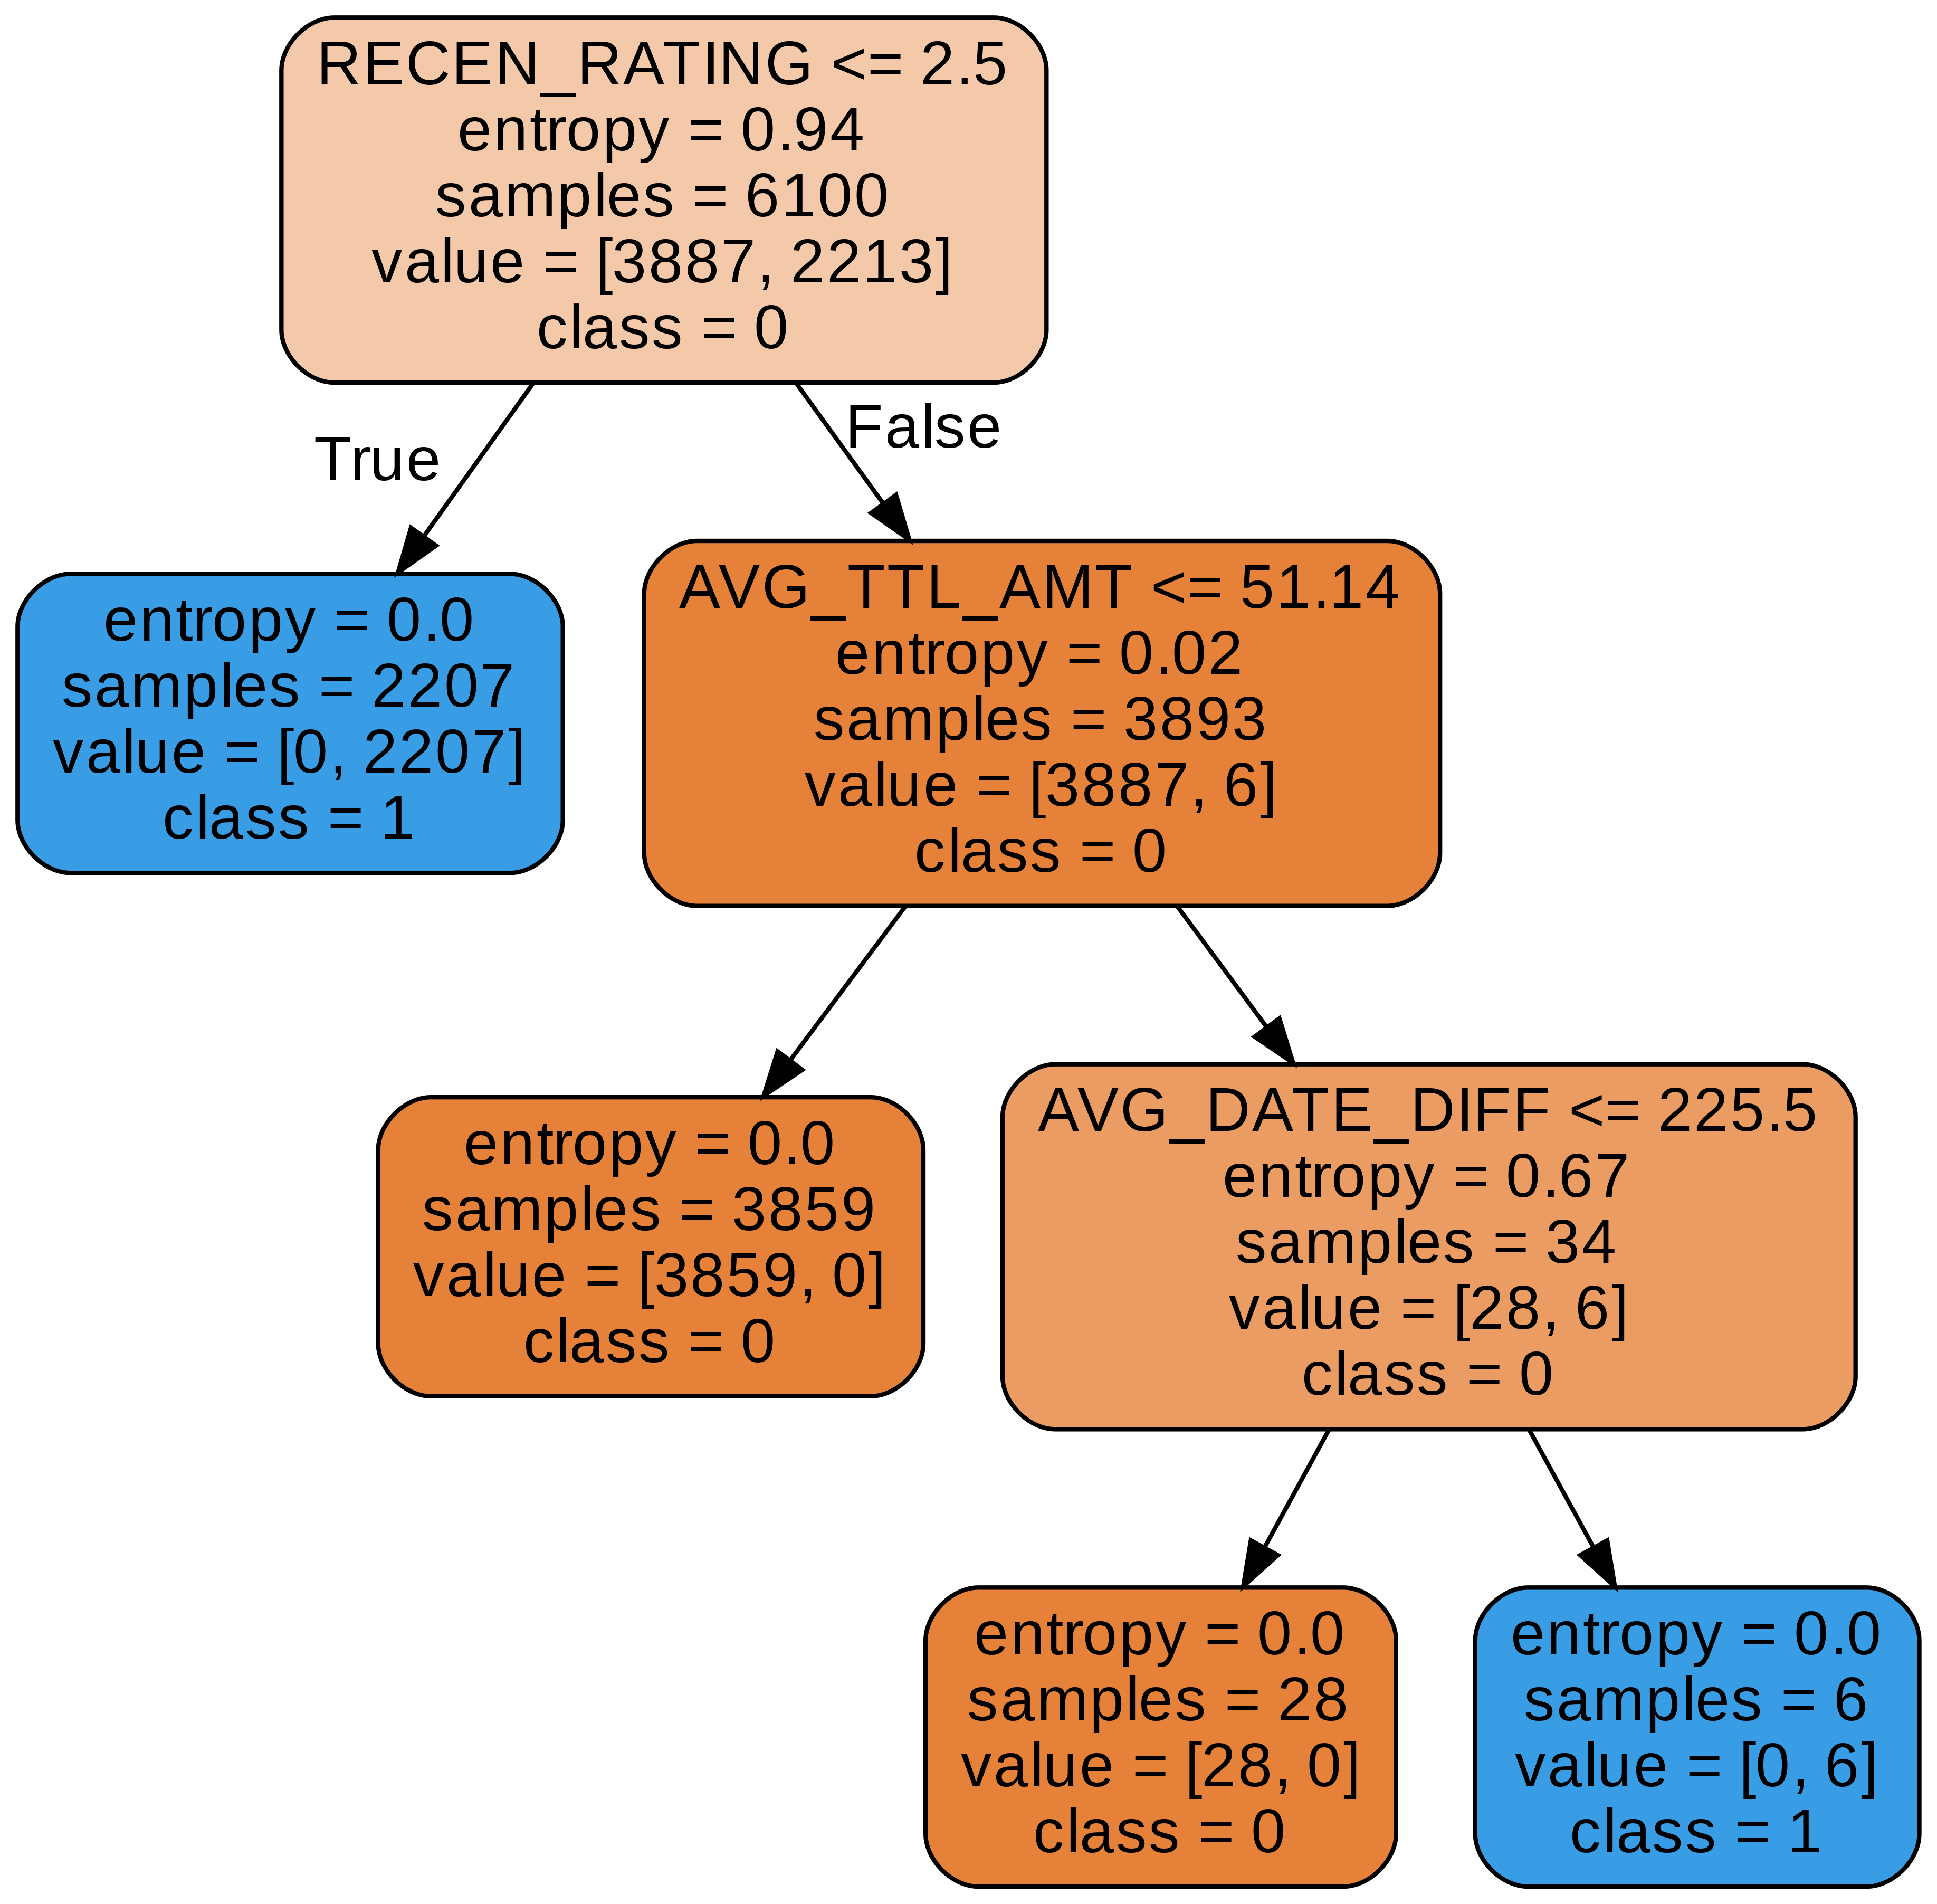

In [82]:
Image(filename = 'DCS_TREE_CLS1.png')

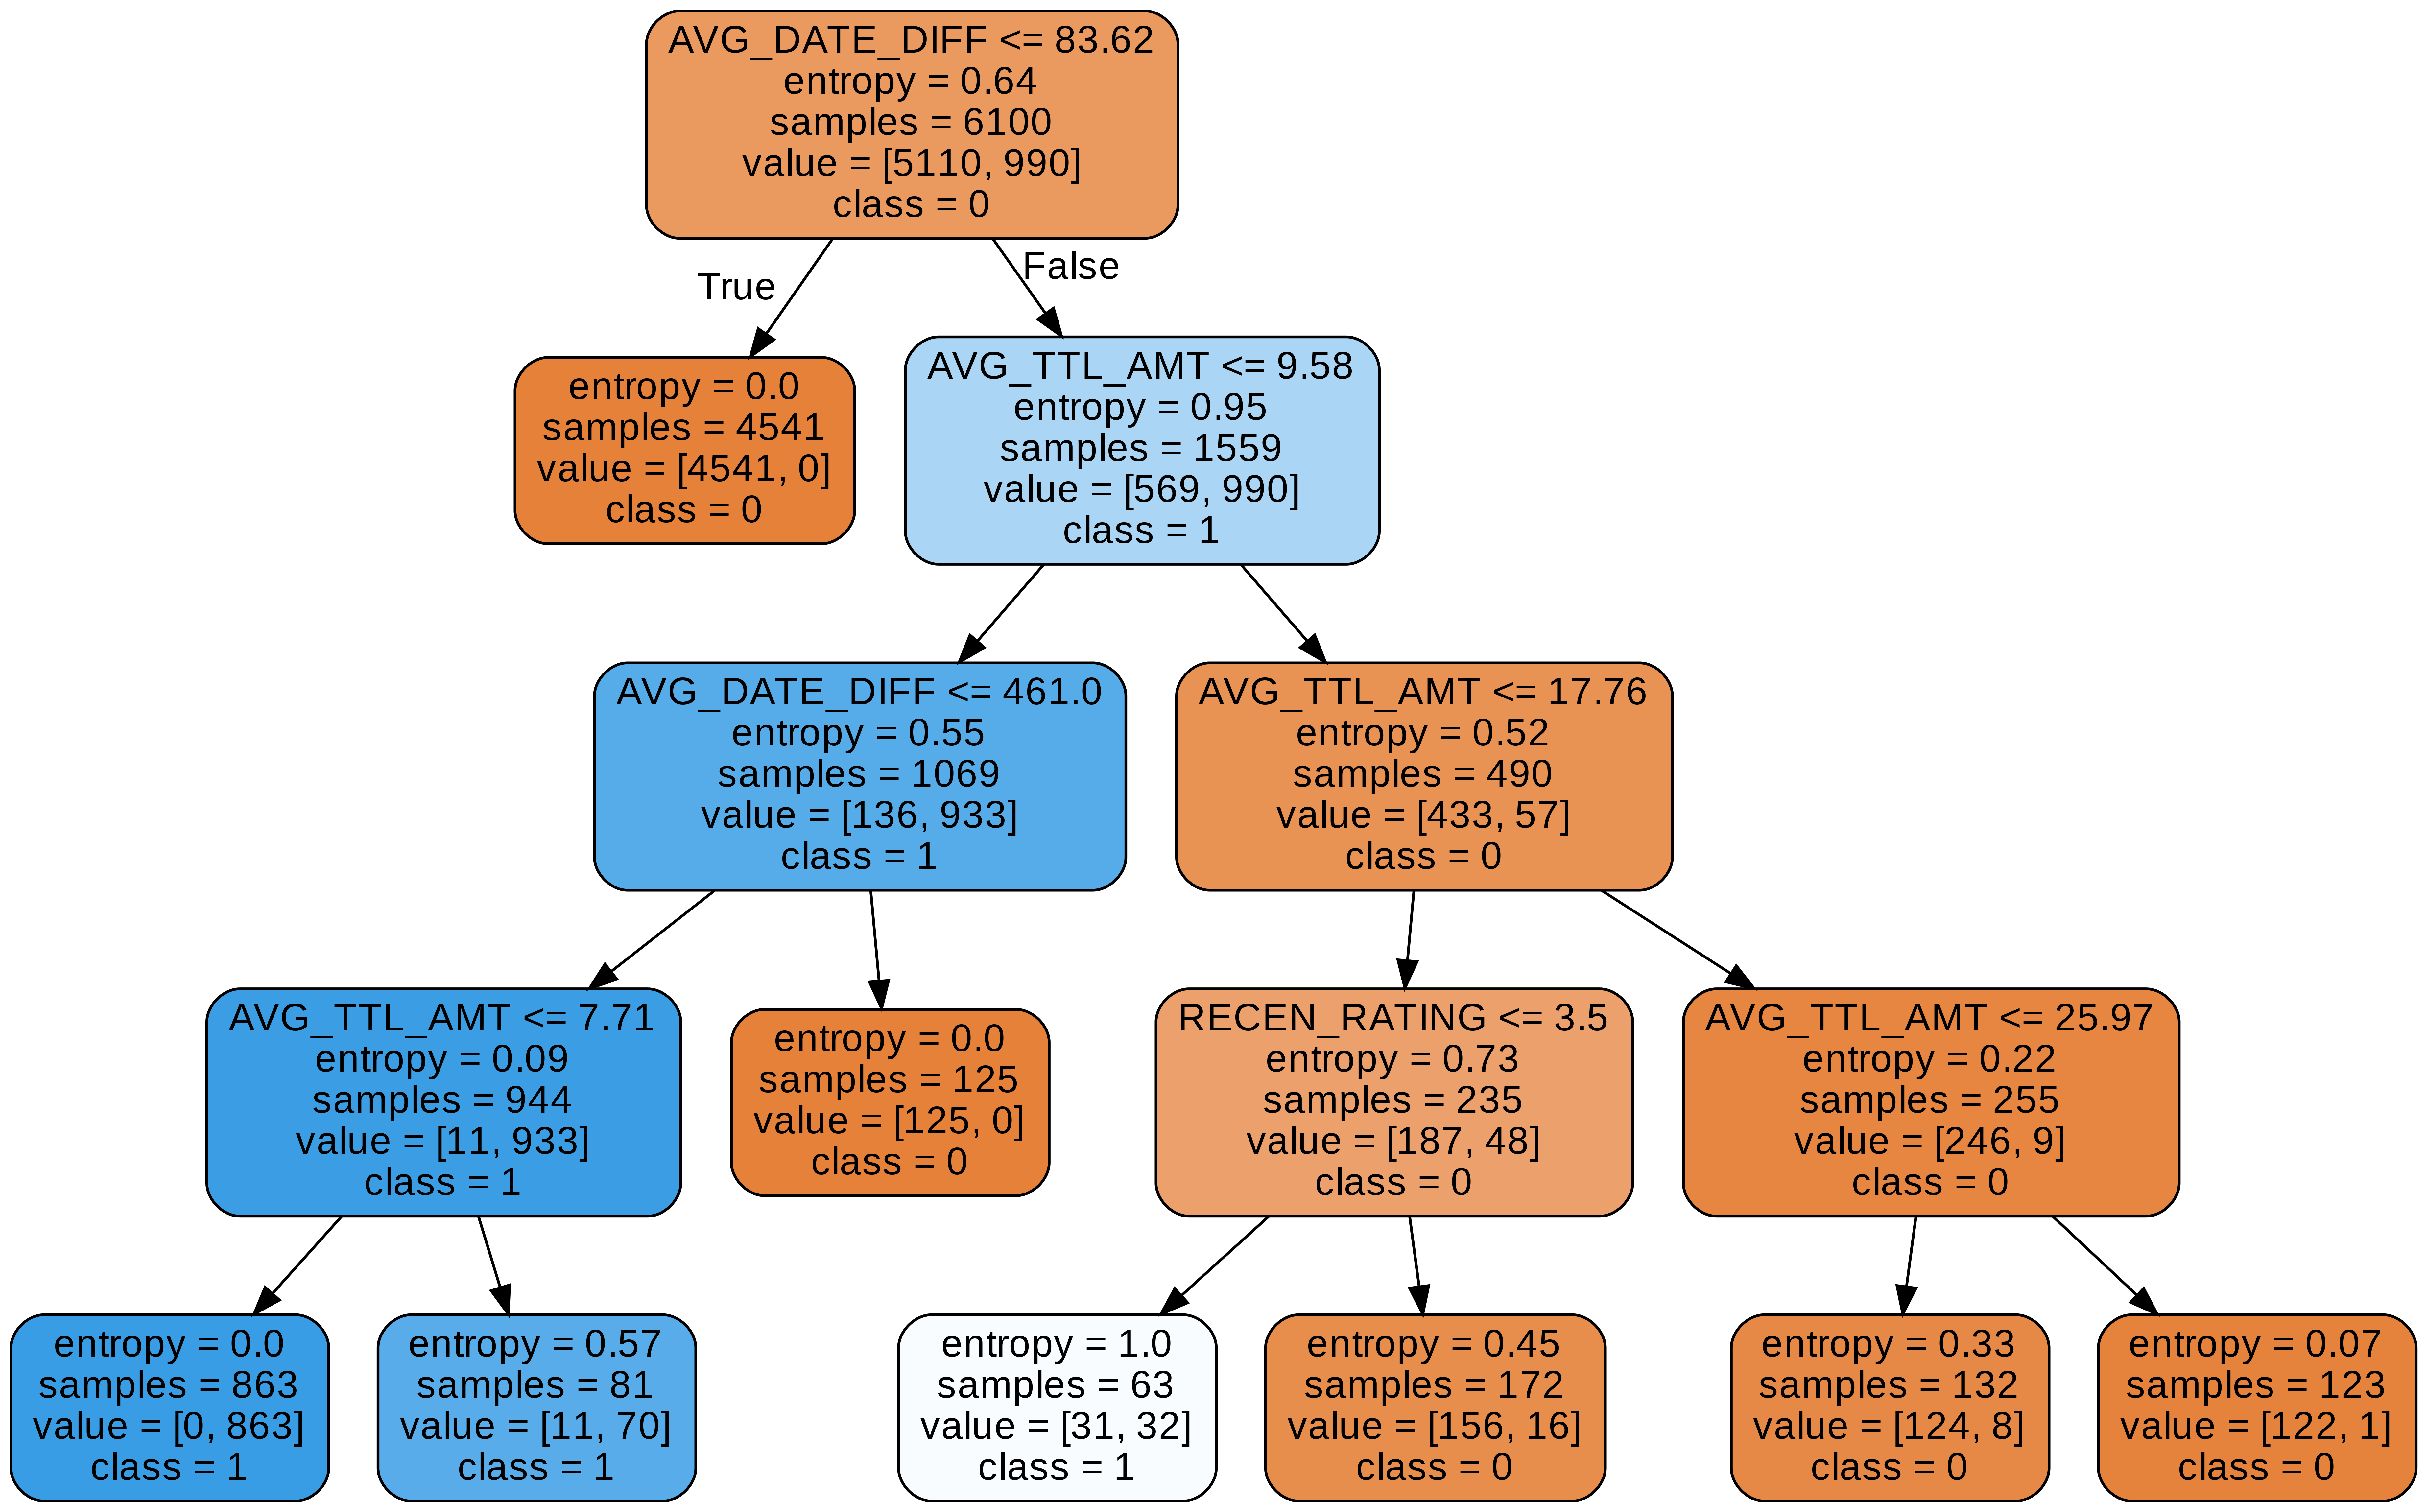

In [83]:
Image(filename = 'DCS_TREE_CLS2.png')

In [84]:
Image(filename = 'DCS_TREE_CLS3.png')

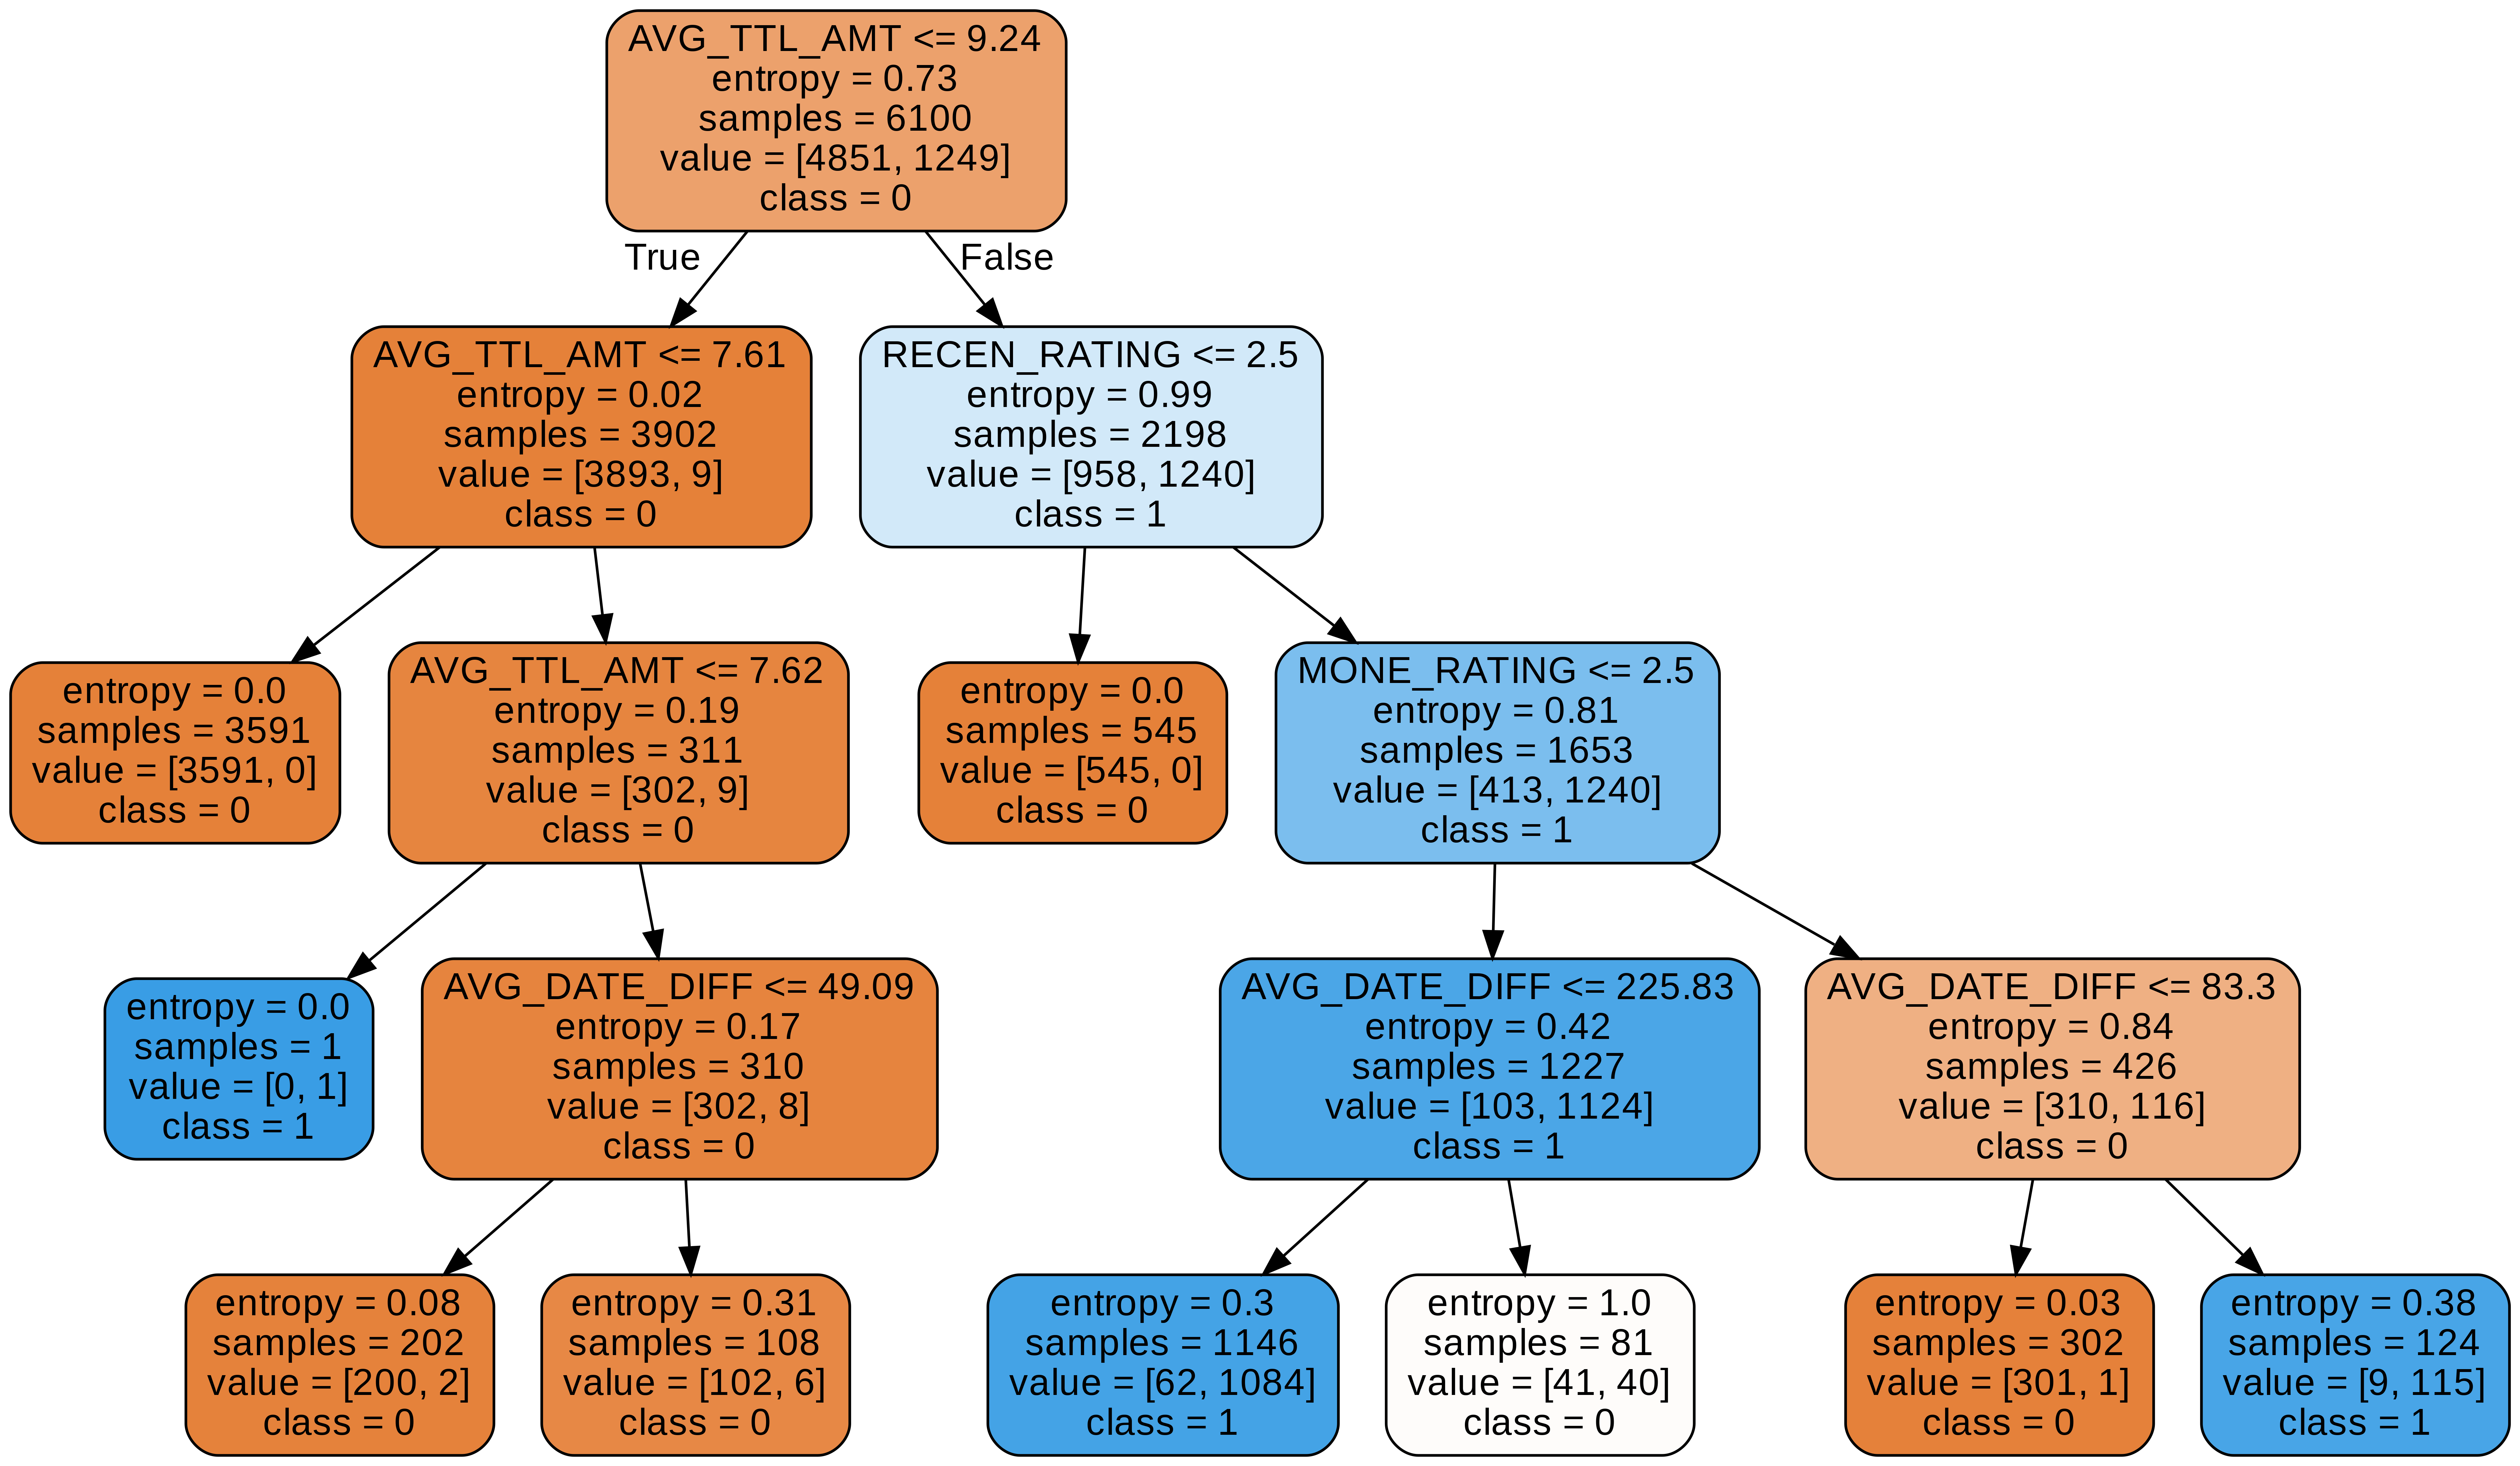

In [85]:
Image(filename = 'DCS_TREE_CLS4.png')

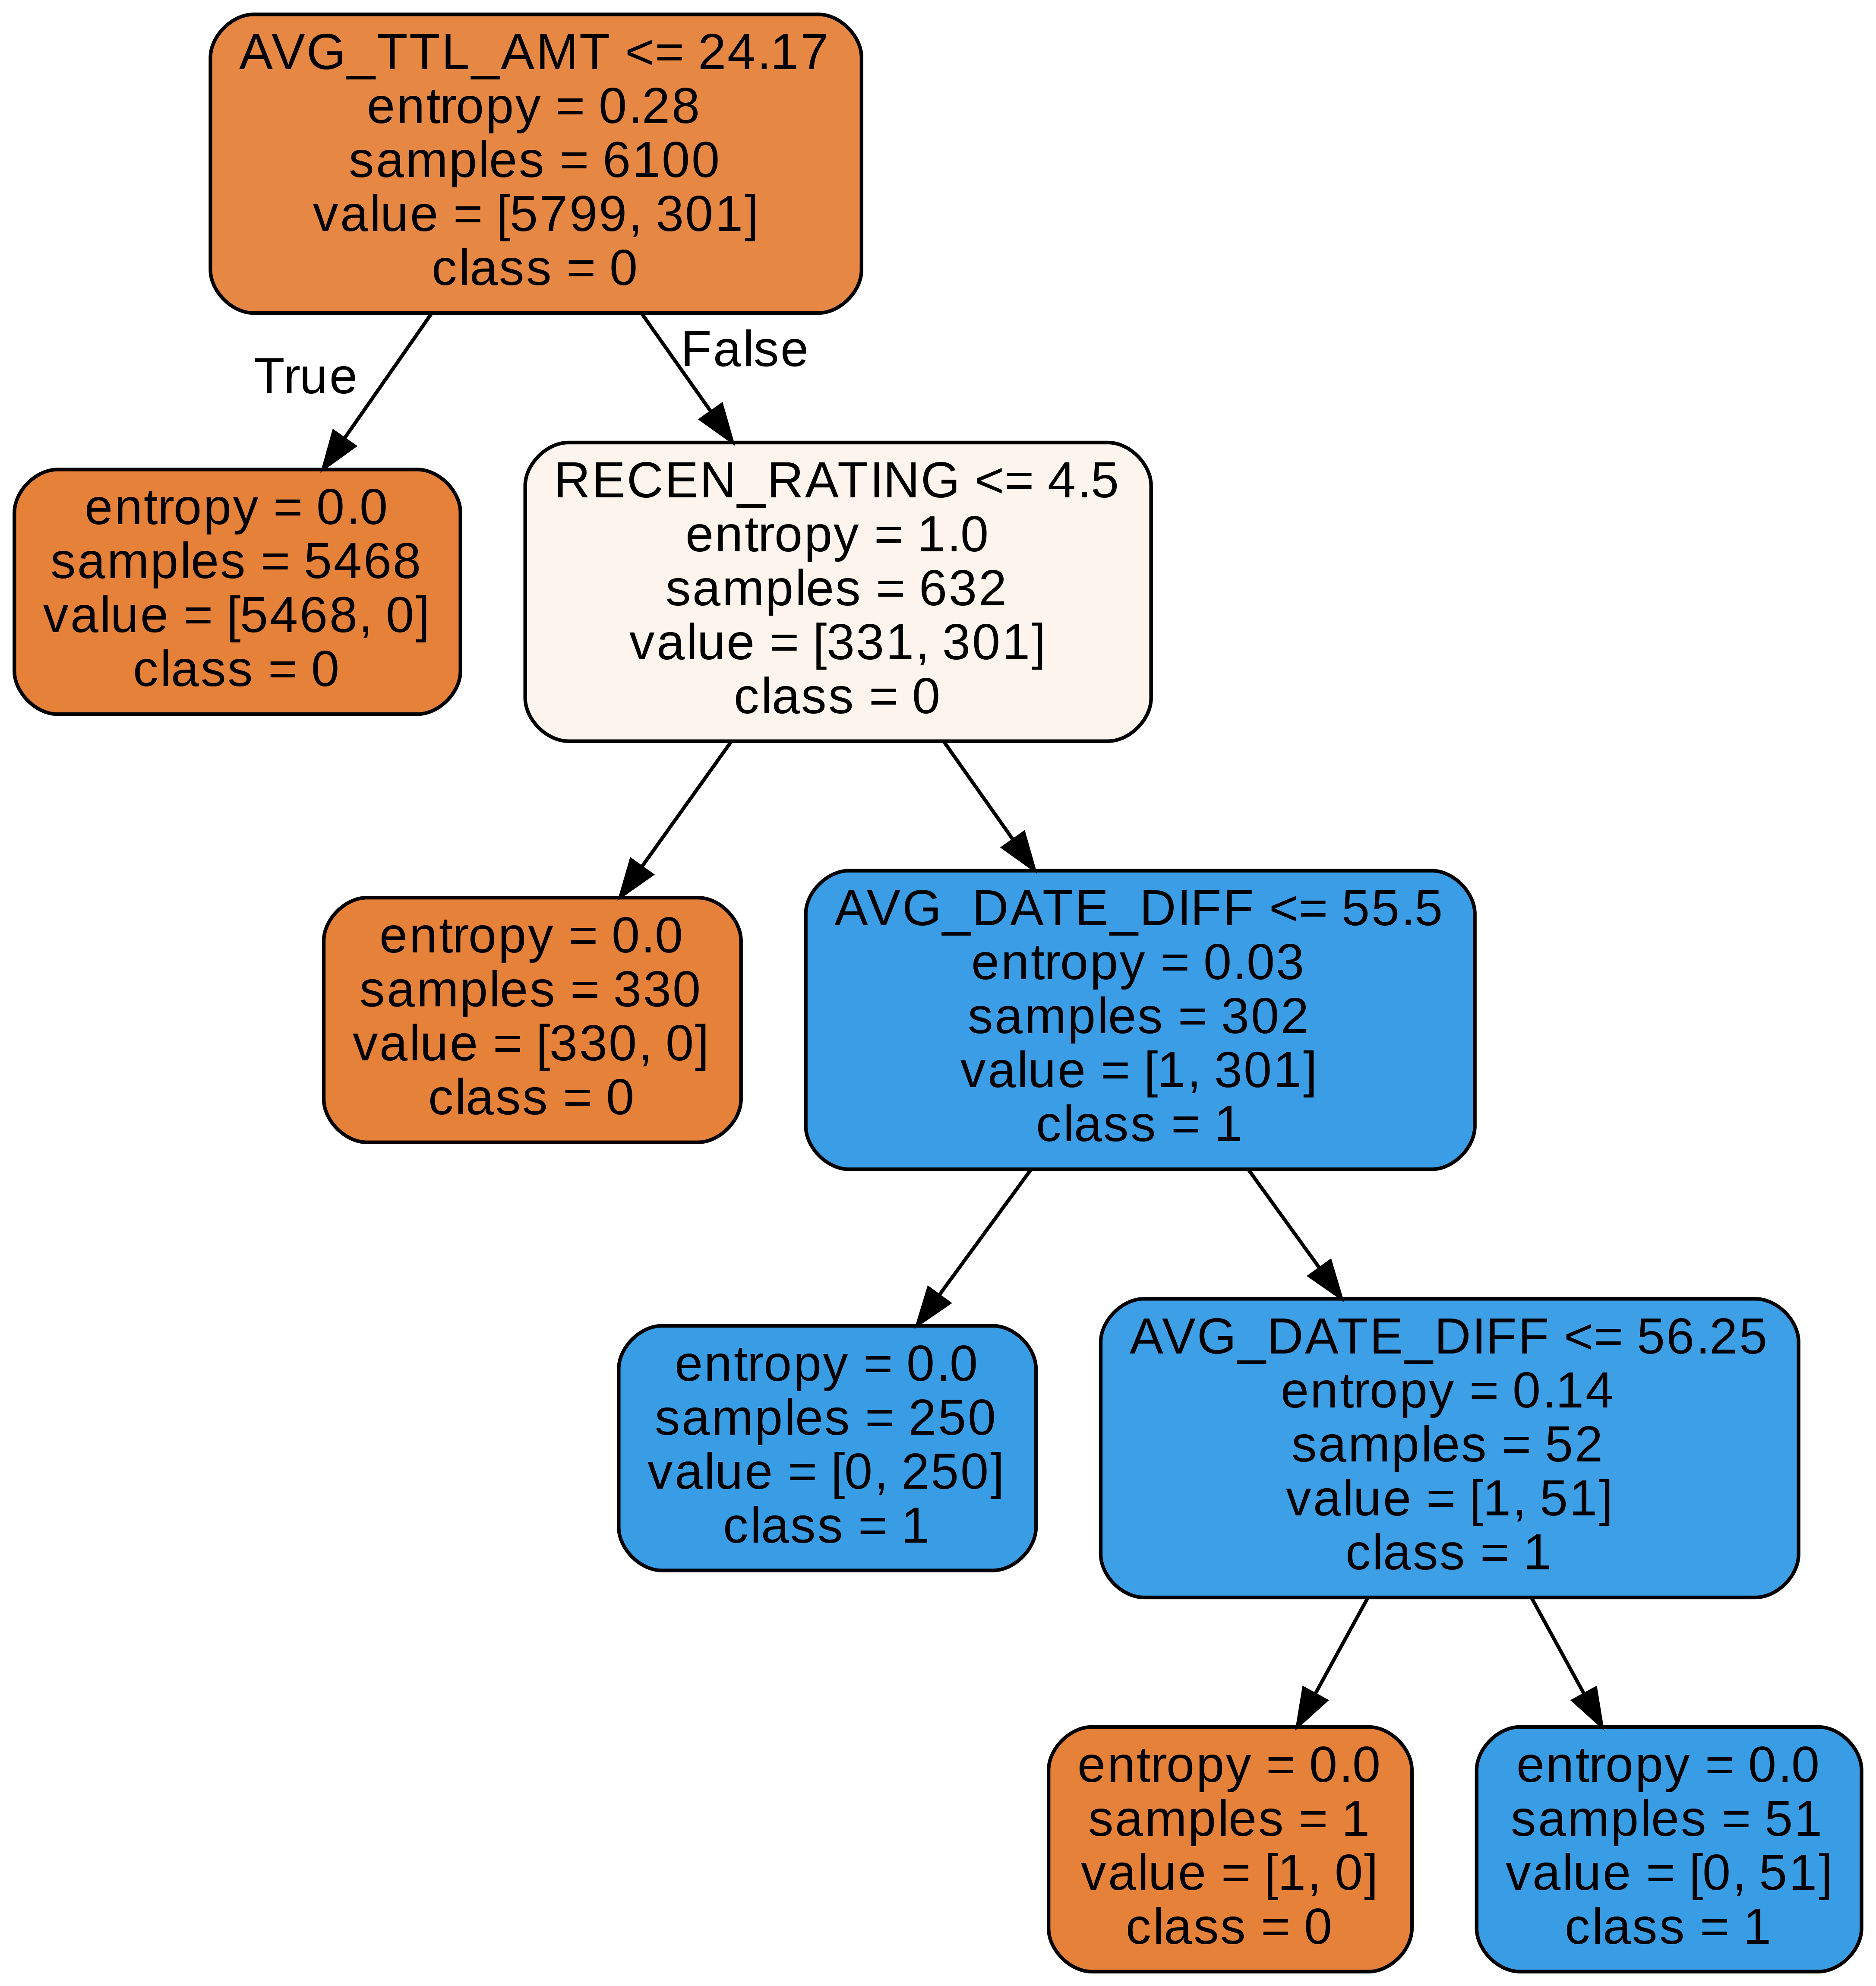

In [86]:
Image(filename = 'DCS_TREE_CLS5.png')